In [38]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster


In [39]:
# change the path 
path = "../reformate"
os.chdir(path)


In [40]:
USE_SIMPLE_DATA = False

In [41]:
transfermap = {
    '頂標': 88,
    '前標': 75,
    '均標': 50,
    '後標': 25,
    '底標': 12,
    'nan': 0

}
codeList = ['國文檢定_code','英文檢定_code','數學檢定_code',
            '社會檢定_code','自然檢定_code']
codeList2 = ['國文採計','英文採計','數學採計','社會採計','自然採計']
codeList3 = ['國文倍率','英文倍率','數學倍率','社會倍率','自然倍率']
codeList4 = ['unitier','預定甄試人數','甄試費用','口試佔比','書審佔比']

In [42]:
#import data
simpdf = pd.read_csv('./rawData/109_selfapplication_university_cleaned.csv')
rawdf = pd.read_stata('./rawData/109 Selfapplication_V6.dta')

In [43]:
#let the order become same
rawdf['學校名稱_eng_encoded'] = rawdf['學校名稱_eng_encoded'].astype('str')
rawdf.sort_values(by=['學校名稱_eng_encoded','school'], inplace=True)

In [44]:
# clean simp data
label = simpdf.columns
simpdf["id"] = np.arange(0, len(simpdf))
simp_label_df = simpdf[['id', 'university', 'school', 'school_index', 'unitier']]
simpdf = simpdf.drop(['university', 'school', 'id', 'school_index', 'unitier'], axis=1)


In [45]:
#clean raw data
rawdf = rawdf[['學校名稱_code', '學校名稱_encoded', '學系名稱_trim', '學系代碼', '國文檢定_code', '英文檢定_code',
         '數學檢定_code',
         '社會檢定_code', '自然檢定_code', '國文倍率', '英文倍率', '數學倍率', '社會倍率', '自然倍率', '國文採計',
         '英文採計',
         '數學採計', '社會採計', '自然採計', '自設科目組合_code', '自設科目組合倍率', '預定甄試人數',
         '甄試費用', '口試佔比', '書審佔比']]
rawdf['unitier'] = simp_label_df['unitier']


for idx, row in rawdf.iterrows():
    for _ in codeList2:
        rawdf.loc[idx,_] = float(rawdf.loc[idx,_] * rawdf.loc[idx,'自設科目組合倍率'])
    for _ in codeList:
        rawdf[_] = rawdf[_].astype('str')
        rawdf.loc[idx,_] = transfermap[rawdf.loc[idx,_]]

for _ in codeList:
    rawdf[_] = rawdf[_].astype('int')

for col in codeList3:
    rawdf[col] = rawdf[col].apply(lambda x: -np.log10(x) if x != 0 else -np.log(30))
rawdf['unitier'] = rawdf['unitier'].apply(lambda x: 4-x)

raw_label_df = rawdf[['學校名稱_code', '學校名稱_encoded', '學系名稱_trim', '學系代碼','國文採計',
              '英文採計',
              '數學採計', '社會採計', '自然採計', '自設科目組合_code', '自設科目組合倍率', 'unitier', '預定甄試人數',
              '甄試費用', '口試佔比', '書審佔比']]
rawdf = rawdf.drop(columns = ['學校名稱_code', '學校名稱_encoded', '學系名稱_trim', '學系代碼','國文採計',
                           '英文採計',
                           '數學採計', '社會採計', '自然採計', '自設科目組合_code', '自設科目組合倍率', 'unitier', '預定甄試人數',
                           '甄試費用', '口試佔比', '書審佔比'])

In [46]:
# choose which data to use 
if USE_SIMPLE_DATA:
    data = simpdf
    label_df = simp_label_df
else:
    data = rawdf
    label_df = raw_label_df

In [47]:
# t-SNE Process

# Standardize the data
scaler = StandardScaler()
stddata = scaler.fit_transform(data)

# t-SNE
if USE_SIMPLE_DATA:
    perplexity = 30
else:
    prelexity = 35
    
tsne = TSNE(init = 'pca',n_components=2, random_state=0, perplexity=35, n_iter=1000)
tsne_data = tsne.fit_transform(stddata)


In [48]:
#linkage cluster
linkage_matrix = linkage(tsne_data, method='average', metric='euclidean')
cluster = fcluster(linkage_matrix,t = 7 , criterion='maxclust')
label_df['cluster'] = cluster


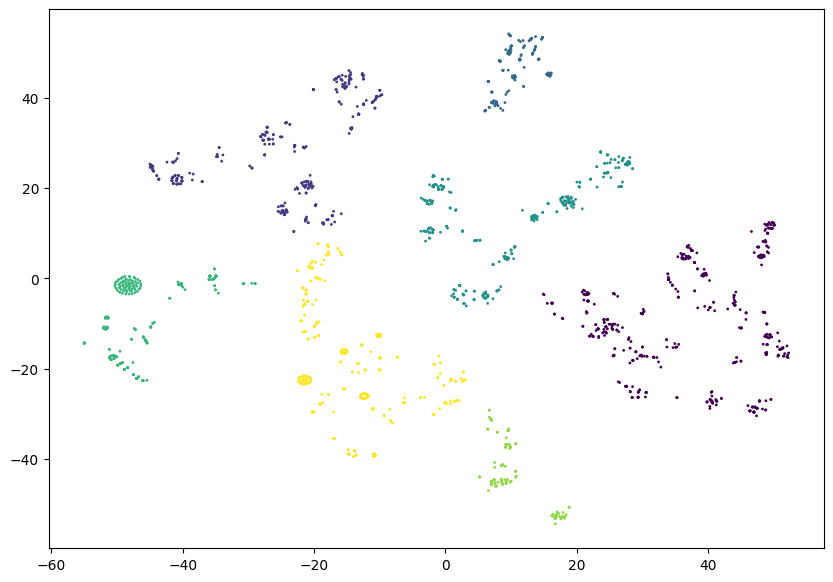

In [49]:
#plot results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=cluster,s = 1)
plt.savefig(f"./pics/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.png")

In [50]:
# save results
if USE_SIMPLE_DATA:
    data = rawdf
    label_df = raw_label_df
    label_df['cluster'] = cluster
data = pd.concat([data, label_df], axis=1)
data.to_csv(f"./processedData/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.csv")

# Analysis the results of t-SNE 

1. show the different 
2. do some test
3. output the results by latex table

In [51]:
# import data
print("Use simple data = ",USE_SIMPLE_DATA)
data = pd.read_csv(f"./processedData/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.csv")

Use simple data =  False


In [52]:
# the statistics of cluster attrs

try:
    dataNoName = data.drop(columns = ['學校名稱_encoded','學系名稱_trim','學系代碼','Unnamed: 0'])
except:
    dataNoName = data.drop(columns = ['學校名稱_encoded','學系名稱_trim','學系代碼'])
attrsByCluster = dataNoName.groupby('cluster').agg(['mean','std','count'])


In [53]:
# test the mean of different cluster is equal or not, first test nomalty
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import kruskal

for col in dataNoName.columns:
    tval = True
    for subcol in [dataNoName[dataNoName['cluster'] == cls][col] for cls in range(1,8)]:
        if shapiro(subcol)[1] < 0.05:
            tval = False
            break
    if tval > 0.05:
        #print(f"{col} is normal")
        print(f"{col} : F-statistic is {f_oneway(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[0] :.3f}, p-vlaue is {f_oneway(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[1] :.3f}. \n the different of each group is {'signifact' if kruskal(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[1] < 0.05 else 'not signifact'}")
    else:
        #print(f"{col} is not normal")
        print(f"{col} : Kruskal statistic is {kruskal(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[0] :.3f}, p-vlaue is {kruskal(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[1] :.3f}.\n the different of each group is  {'signifact' if kruskal(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[1] < 0.05 else 'not signifact'}")


國文檢定_code : Kruskal statistic is 131.158, p-vlaue is 0.000.
 the different of each group is  signifact
英文檢定_code : Kruskal statistic is 441.445, p-vlaue is 0.000.
 the different of each group is  signifact
數學檢定_code : Kruskal statistic is 651.783, p-vlaue is 0.000.
 the different of each group is  signifact
社會檢定_code : Kruskal statistic is 880.065, p-vlaue is 0.000.
 the different of each group is  signifact
自然檢定_code : Kruskal statistic is 1462.311, p-vlaue is 0.000.
 the different of each group is  signifact
國文倍率 : Kruskal statistic is 882.965, p-vlaue is 0.000.
 the different of each group is  signifact
英文倍率 : Kruskal statistic is 1068.475, p-vlaue is 0.000.
 the different of each group is  signifact
數學倍率 : Kruskal statistic is 1059.218, p-vlaue is 0.000.
 the different of each group is  signifact
社會倍率 : Kruskal statistic is 2094.306, p-vlaue is 0.000.
 the different of each group is  signifact
自然倍率 : Kruskal statistic is 2046.691, p-vlaue is 0.000.
 the different of each group is  

/usr/local/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [54]:
# output the results by latex table
attrsByCluster.to_latex(f"./results/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.tex")

In [55]:
# output results csv by .png

